In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import knns, SVD, SVDpp, SlopeOne, NMF, BaselineOnly, NormalPredictor
from surprise.similarities import cosine, msd, pearson, pearson_baseline

plt.style.use('fast')
%matplotlib inline

In [2]:
df_rev5 = pd.read_csv('Data/df_rev5.csv')

In [3]:
df_rev5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307556 entries, 0 to 1307555
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1307556 non-null  int64 
 1   overall     1307556 non-null  int64 
 2   reviewerID  1307556 non-null  object
 3   asin        1307556 non-null  object
 4   reviewText  1307550 non-null  object
dtypes: int64(2), object(3)
memory usage: 49.9+ MB


In [4]:
df_rev5.isna().sum()

Unnamed: 0    0
overall       0
reviewerID    0
asin          0
reviewText    6
dtype: int64

In [5]:
df_rev5.dropna(inplace=True)

In [6]:
reader = Reader(rating_scale=(1, 5))
user_data = Dataset.load_from_df(df_rev5[['reviewerID', 'asin', 'overall']], reader)

trainset, testset = train_test_split(user_data, test_size=0.2, random_state=42)

In [7]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  98033 

Number of items:  92347 



In [13]:
baseline = NormalPredictor()
baseline.fit(trainset)
predictions = baseline.test(testset)
baseline_normal = accuracy.rmse(predictions)

RMSE: 1.2355


1.2354699762635104

In [15]:
baseline2 = BaselineOnly()
baseline2.fit(trainset)
predictions = baseline2.test(testset)
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8155


In [16]:
svd_basic = SVD(random_state=42)
results = cross_validate(svd_basic, user_data, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8155  0.8122  0.8146  0.8141  0.0014  
Fit time          40.53   40.41   40.82   40.59   0.17    
Test time         3.50    3.62    3.54    3.55    0.05    


In [18]:
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)
svd_simple = accuracy.rmse(predictions)

RMSE: 0.8041


In [ ]:
svd_param_grid = {'n_factors':[20, 40],
                  'n_epochs': [10, 20], 
                  'lr_all': [0.002, 0.005],
                  'reg_all': [0.02 ,0.04, 0.06],
                  'biased': [True, False]}
svd_gs_model = GridSearchCV(SVD,param_grid=svd_param_grid,joblib_verbose=5,cv=3)
svd_gs_model.fit(user_data)
svd_gs_model.best_params['rmse']

In [31]:
svd_model = SVD(n_factors=20, n_epochs=20,
                lr_all=.005, reg_all=0.02, random_state=42)
svd_model.fit(trainset)
predictions = svd_model.test(testset)
svd_gs1 = accuracy.rmse(predictions)

RMSE: 0.7950


In [ ]:
svd_param_grid2 = {'n_factors':[5, 10, 20],
                  'n_epochs': [20, 30, 40], 
                  'lr_all': [0.5, 0.05, .005],
                  'reg_all': [0.01, 0.02]}
svd_gs2_model = GridSearchCV(SVD,param_grid=svd_param_grid2,joblib_verbose=5, cv=3)
svd_gs2_model.fit(user_data)
svd_gs2_model.best_params['rmse']

In [32]:
svd2_model = SVD(n_factors=5, n_epochs=40, lr_all=0.005, reg_all=0.02, random_state=42)
svd2_model.fit(trainset)
predictions = svd2_model.test(testset)
svd_gs2 = accuracy.rmse(predictions)

RMSE: 0.7829


In [ ]:
svd_param_grid3 = {'n_factors':[1, 3, 5],
                   'n_epochs':[40, 50],
                   'lr_all':[0.01, 0.005, 0.001],
                   'reg_all':[0.02, 0.01]}
svd_gs3_model = GridSearchCV(SVD, param_grid=svd_param_grid3, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)
svd_gs3_model.fit(user_data)
svd_gs3_model.best_params['rmse']

In [9]:
svd3_model = SVD(n_factors=1, n_epochs=50, lr_all=0.005, reg_all=0.02, random_state=42)
svd3_model.fit(trainset)
predictions = svd3_model.test(testset)
svd_gs3 = accuracy.rmse(predictions)

RMSE: 0.7813


In [ ]:
nmf_param_grid = {'biased':[True, False],
                  'n_factors':[15, 10, 5, 1],
                  'n_epochs': [25, 50]}
nmf_gs_model = GridSearchCV(NMF, param_grid=nmf_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)
nmf_gs_model.fit(user_data)
nmf_gs_model.best_params['rmse']

In [26]:
nmf_model = NMF(n_factors=1, n_epochs=50, random_state=42, biased=True)
nmf_model.fit(trainset)
predictions = nmf_model.test(testset)
nmf_gs = accuracy.rmse(predictions)

RMSE: 0.7844


In [ ]:
svdpp_param_grid = {'n_factors':[1, 5, 10],
                    'n_epochs':[25, 50],
                    'lr_all':[0.005, 0.007],
                    'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)
svdpp_gs_model.fit(user_data)
svdpp_gs_model.best_params['rmse']

In [30]:
SVDpp_model = SVDpp(n_factors=1, n_epochs=50, random_state=42, reg_all=0.05)
SVDpp_model.fit(trainset)
predictions = SVDpp_model.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

RMSE: 0.7838


In [63]:
X = ['Baseline Only', 'SVD Basic', 'SVD GS1', 'NMF GS', 'SVDpp GS', 'SVD GS3']
y = [baseline_only, svd_simple, svd_gs1, nmf_gs, SVDpp_gs, svd_gs3]

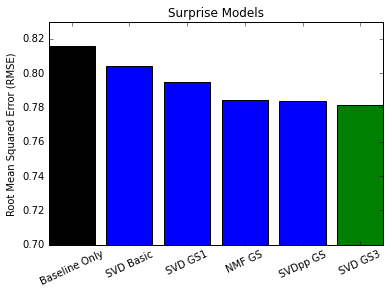

In [123]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(0.7,.83)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/Model_bar.png', dpi=300, bbox_inches='tight');

In [10]:
trainset_full = user_data.build_full_trainset()
svd3_model.fit(trainset_full)

In [44]:
pickle.dump(svd3_model, open('Model/collab_model.sav', 'wb'))

In [11]:
df_meta5 = pd.read_csv('Data/meta5.csv', index_col='asin')
df_meta5.drop(columns =['Unnamed: 0'], inplace=True)

In [12]:
df_meta5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93734 entries, B0012GTZCK to B01HJCNGZ2
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         93734 non-null  object 
 1   author        93734 non-null  object 
 2   genre         93734 non-null  object 
 3   print_length  93734 non-null  float64
 4   word_wise     93734 non-null  float64
 5   lending       93734 non-null  float64
dtypes: float64(3), object(3)
memory usage: 5.0+ MB


In [13]:
df_meta5.head()

,title,author,genre,print_length,word_wise,lending
asin,,,,,,
B0012GTZCK,God in the White House,Randall Balmer,History,260.0,1.0,0.0
B0012LHGJ4,Vingt Mille Lieues sous les mers (French Editi...,Jules Verne,Reference,606.0,0.0,1.0
B0012RMVH0,Wood-Carving Design and Workmanship - Kindle e...,George Jack,Arts & Photography,310.0,0.0,0.0
B0012TAD1O,Souls Night (The Vampire Pacts) - Kindle edition,Kallysten,Romance,74.0,1.0,1.0
B0012U0NKE,The Misplaced Horse (1) eBook,Constance Downes,"Comics, Manga & Graphic Novels",444.0,0.0,1.0


In [14]:
df_user = df_rev5.set_index('reviewerID')
df_user.drop(columns=['Unnamed: 0', 'reviewText', 'overall'], inplace=True)

In [15]:
df_user

,asin
reviewerID,
AYKIGSPZ8TLR7,B0012LHGJ4
AV4TJUAJJL3IV,B0012RMVH0
AQR816QPFU5JE,B0012RMVH0
A1KURTCUDMSNF4,B0012RMVH0
A3GDLS2QG56059,B0012RMVH0
...,...
A1M2UIBQGKEUAU,B01HJCNGZ2
A2GCEOF7KVQK1U,B01HJCNGZ2
A3ETWQJ8WRQFHX,B01HJCNGZ2


In [15]:
df_user.to_csv('Data/df_user.csv')

In [16]:
def user_recommend_books():
    
    user = input('UserId: ')
    n_recs = int(input('How many recommendations? '))
    
    have_reviewed = list(df_user.loc[user, 'asin'])
    not_reviewed = df_meta5.copy()
    not_reviewed.drop(have_reviewed, inplace=True)
    not_reviewed.reset_index(inplace=True)
    not_reviewed['est_rating'] = not_reviewed['asin'].apply(lambda x: svd3_model.predict(user, x).est)
    not_reviewed.sort_values(by='est_rating', ascending=False, inplace=True)
    return not_reviewed.head(n_recs)

In [17]:
user_recommend_books()

UserId: A26GE9ZG68SKIQ
How many recommendations? 10


,asin,title,author,genre,print_length,word_wise,lending,est_rating
46277,B00M64QIWW,John & Jackie - Kindle edition,TJ Klune,Literature & Fiction,95.0,1.0,1.0,4.962664
50633,B00O02AMKW,Snowfall (Novella) - Kindle edition,Mary Ann Rivers,Literature & Fiction,143.0,1.0,0.0,4.936640
71628,B012WCOYQ4,The Rise of Ren Crown eBook,Anne Zoelle,Children's eBooks,449.0,1.0,1.0,4.906841
58577,B00SEKT3M4,The Player (Rockliffe Book 3) - Kindle edition,Stella Riley,Literature & Fiction,327.0,1.0,1.0,4.904327
6145,B006BG7Q1I,Love Intertwined Vol. 1 - Kindle edition,Pepper Pace,Literature & Fiction,222.0,1.0,1.0,4.898928
75479,B015WXSNFI,Holy Spy: A John Shakespeare Mystery - Kindle ...,Rory Clements,"Mystery, Thriller & Suspense",485.0,1.0,0.0,4.888171
50674,B00O0AG24Y,Inspector Hobbes and the Gold Diggers: Comedy ...,Wilkie Martin,"Mystery, Thriller & Suspense",329.0,1.0,1.0,4.887218
18478,B00BR70E2E,Captain Lacey Regency Mysteries Volume Two - K...,Ashley Gardner,"Mystery, Thriller & Suspense",899.0,1.0,1.0,4.873885
72600,B013WZRWMS,Ships and Stings and Wedding Rings (The Chron...,Jodi Taylor,Science Fiction & Fantasy,51.0,1.0,0.0,4.872621
39149,B00JH6HSQW,"A Woman of Experience (The Sojourners Series, ...",Kay Gregory,Literature & Fiction,394.0,1.0,1.0,4.862539
